# Reversible adiabatic descent tests

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import metpy.calc as mpcalc
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT
import metpy.constants as const

import sys

sys.path.append('../scripts/')
from thermo import moist_lapse, reversible_lapse, saturation_specific_humidity

In [44]:
pressure = np.arange(500, 1001, 50)*units.mbar
t_initial = -15*units.celsius

In [45]:
%%time
t_integration = moist_lapse(pressure, t_initial, method='integration')

CPU times: user 107 ms, sys: 2.99 ms, total: 110 ms
Wall time: 279 ms


In [46]:
%%time
t_fast = moist_lapse(pressure, t_initial, method='fast')

CPU times: user 101 ms, sys: 3.54 ms, total: 104 ms
Wall time: 151 ms


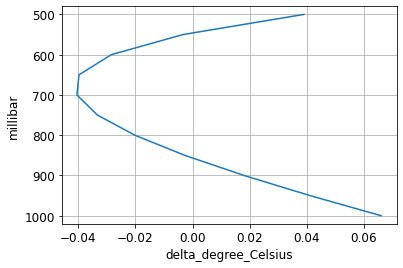

In [47]:
fig, ax = plt.subplots()
ax.plot(t_fast - t_integration, pressure)
ax.set_ylim(1020, 480)
ax.grid()

In [48]:
# initially saturated parcel
q_initial = saturation_specific_humidity(pressure[0], t_initial)
# values for moist descent only
t_max_final = moist_lapse(pressure[-1], t_initial, pressure[0])
q_max_final = saturation_specific_humidity(pressure[-1], t_max_final)
q_max_final - q_initial

0.009251683539496569 <Unit('dimensionless')>

In [54]:
%%time
t_reversible = reversible_lapse(
    pressure, t_initial, q_initial, 10e-3*units.dimensionless, improve=2)

CPU times: user 241 ms, sys: 10.4 ms, total: 251 ms
Wall time: 360 ms


[Text(0.5, 0, 'Reversible minus pseudoadiabatic temperature'),
 Text(0, 0.5, 'Pressure')]

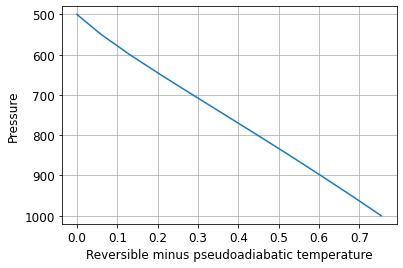

In [55]:
fig, ax = plt.subplots()
ax.plot(t_reversible - t_integration, pressure)
ax.set_ylim(1020, 480)
ax.grid()
ax.set(
    xlabel='Reversible minus pseudoadiabatic temperature',
    ylabel='Pressure')

Major problem: reversible parcel should be colder than pseudoadiabatic parcel when descending